### 20190905: Analysis of differential contact beween healthy and _Salmonella enterica_-infected mice
**cmdoret**

I generated Hi-C maps at multiple resolutions between 10 and 640kb and used diffHic to detect bins with changes in directionality index. It works based on edgeR model (GLM fitting). This gives a list of bin ranges where the domain boundaries are affected which are potentially interesting.

In [186]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [1]:
# Load files and packages
import numpy as np
import pandas as pd
import os
import warnings
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import hicstuff.hicstuff as hcs
import hicstuff.view as hcv
import cooler
import pybedtools


out = '../data/output/'
indir = '../data/input/'
healthy_cool = cooler.Cooler(out + 'cool/AT337.mcool::/resolutions/160000')
infected_cool = cooler.Cooler(out + 'cool/PM106.mcool::/resolutions/160000')
healthy_bedgraph = pd.read_csv(out + 'all_signals_AT337.bedgraph', sep='\t')
infected_bedgraph = pd.read_csv(out + 'all_signals_PM106.bedgraph', sep='\t')
diff_contacts = pd.read_csv(out + 'diffhic/diff_domain_boundaries.txt', sep='\t')
genes = pd.read_csv(indir + 'tracks/mm10_annotations.tsv', sep='\t')
# Remove genes which do not have an entrez id
genes = genes.loc[~np.isnan(genes.entrezgene_id), :]
genes.entrezgene_id = genes.entrezgene_id.astype(int)


OSError: Unable to open file (unable to open file: name = '../data/output/cool/PM51.mcool', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Only regions with p-values below 10e-3 are selected as potential candidates. When replicates will be available, I will use FDR instead of simple p-value.

In [2]:
# Filter hits by p-value
good_diff = diff_contacts.loc[diff_contacts.PValue < 10e-4]
good_diff = good_diff.sort_values(by=['PValue', 'logFC']).reset_index(drop=True)
diff_bed = good_diff.loc[:,['seqnames', 'start', 'end']]
diff_bed.to_csv(out+'sig_diff.bed', sep='\t', index=False, header=None)

In [3]:
good_diff.head()

,seqnames,start,end,infected,uninfected,logFC,logCPM,F,PValue,FDR
0,chr6,124320044,124480044,-0.607918,-1.366190,0.758272,4.043153,21.578595,0.000265,0.974824
1,chr7,96959875,97119990,1.324214,2.175883,-0.851669,3.905914,20.749773,0.000319,0.974824
2,chr10,68639892,68799936,-0.834161,-0.172903,-0.661258,4.310497,19.217835,0.000456,0.974824
3,chr1,100160118,100320023,-0.909955,-0.148916,-0.761040,3.355626,19.066565,0.000473,0.974824
4,chr18,5920230,6079937,-1.379407,-0.773004,-0.606403,4.625793,18.968927,0.000484,0.974824


In [4]:
warnings.filterwarnings('ignore')
#plt.rcParams['figure.figsize'] = (9.0, 6.0)
# Show example regions
%matplotlib notebook
def plot_regions(healthy_cool, infected_cool, df, region_id):
    
    def region_lines(ax, s, e):
        """Add lines to mark region of differential contacts"""
        style = {"lw": 0.5, "alpha": 0.6, "c": "g"}
        for i in range(3):
            ax[i].axvline(x=s, **style)
            ax[i].axvline(x=e, **style)
            ax[i].axhline(y=s, **style)
            ax[i].axhline(y=e, **style)
    
    def nan_gaussian(U, sigma):
        """Gaussian filter which does not include NAs"""
        import scipy.ndimage as ndi
        V=U.copy()
        V[np.isnan(U)]=0
        VV=ndi.gaussian_filter(V, sigma=sigma)
        W=0*U.copy()+1
        W[np.isnan(U)]=0
        WW=ndi.gaussian_filter(W, sigma=sigma)
        Z=VV/WW   
        return Z
    
    # Extract region of interest
    region = good_diff.iloc[region_id]
    chrom, start, end = region.seqnames, region.start, region.end
    pos = (region.start + region.end) / 2
    ucsc_query = f'{chrom}:{int(max(0, pos-10e6))}-{int(pos+10e6)}'
    
    # Subset matrix
    healthy_zoom = healthy_cool.matrix(balance=True).fetch(ucsc_query)
    infected_zoom = infected_cool.matrix(balance=True).fetch(ucsc_query)
    
    # Blur ratio to improve readability
    infected_blur = nan_gaussian(infected_zoom, sigma=1)
    healthy_blur = nan_gaussian(healthy_zoom, sigma=1)
    log_ratio = np.log2(infected_blur / healthy_blur)
    log_ratio[np.isnan(infected_zoom)] = 0.0
    log_ratio[np.isnan(healthy_zoom)] = 0.0
    
    # Initialize figure
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
    
    # Draw lines
    region_size = (end - start) // 160000
    mid = healthy_zoom.shape[0] // 2
    start_bin, end_bin = mid - region_size, mid + region_size
    region_lines(ax, start_bin, end_bin)
    
    # Make heatmap
    plt.suptitle(f"{chrom}:{start}-{end}")
    ax[0].imshow(np.log2(infected_zoom), cmap="Reds")
    ax[0].set_title("Infected")
    ax[1].imshow(np.log2(healthy_zoom), cmap="Reds")
    ax[1].set_title("Uninfected")
    ax[2].imshow(log_ratio, cmap='bwr', vmin=-2, vmax=2)
    ax[2].set_title("I / U")



from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#show_inter_chr(ot_mat, chrA='chr03', chrB='chr08', var='repeats_prop')
pl = interactive(plot_regions, healthy_cool=fixed(healthy_cool),
                 infected_cool=fixed(infected_cool),
                 df=fixed(good_diff),
                 region_id=range(good_diff.shape[0])
                )
#display(pl)
display(pl)

interactive(children=(Dropdown(description='region_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=0), …

All genes that overlap regions of differential contacts are then selected. This may not be optimal because genes may be separated from their enhancer element without being affected directly. This can happen if a domain boundary moves into the sequence between gene and enhancer.

The enrichment of GO terms (annotations) within regions with altered chromatin conformation is then tested to check for specific pathways or funcions.

In [5]:
# Overlap with annotations
genes_bed_path = indir + 'tracks/mm10_annotations.bed'
(genes
 .loc[:, ["chromosome_name", "start_position", "end_position", "ensembl_gene_id"]]
 .to_csv(genes_bed_path, header=None, index=False, sep='\t')
)
genes_bed = pybedtools.BedTool(indir + 'tracks/mm10_annotations.bed')
diff_bed = pybedtools.BedTool(out + 'sig_diff.bed')
genes_inter_diff = genes_bed.intersect(diff_bed)
genes_inter_diff.saveas(out+'genes_diff.bed')


<BedTool(../data/output/genes_diff.bed)>

In [6]:
# Get corresponding GO terms
genes_diff = pd.read_csv(out+'genes_diff.bed', sep='\t', names=["chrom", "start", "end", "ensembl_gene_id"])
genes_diff = genes_diff.merge(genes, left_on="ensembl_gene_id", right_on="ensembl_gene_id", how="inner")



In [7]:
# Download GO association data required for enrichment test
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_10090_ProteinCoding import GENEID2NT as GeneID2nt_mus
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
# Get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo")
# Read NCBI's gene2go. Store annotations in a list of namedtuples
# taxid 10090 is Mus musculus
objanno = Gene2GoReader(fin_gene2go, taxids=[10090])
# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated mouse genes".format(NS=nspc, N=len(id2gos)))

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2019-07-01) 47,413 GO Terms
HMS:0:00:02.688893 366,685 annotations READ: gene2go 
1 taxids stored: 10090
MF 16,801 annotated mouse genes
CC 18,979 annotated mouse genes
BP 17,808 annotated mouse genes


In [8]:
exp_all_genes = {x: GeneID2nt_mus[x] for x in genes.entrezgene_id if x in GeneID2nt_mus.keys()}
exp_diff_genes = {x: GeneID2nt_mus[x] for x in genes_diff.entrezgene_id if x in GeneID2nt_mus.keys()}

In [9]:
# Build GO enrichment analysis object

goeaobj = GOEnrichmentStudyNS(
        exp_all_genes.keys(), # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 16,049 of 19,974 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 87% 17,448 of 19,974 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 79% 15,692 of 19,974 population items found in association


In [10]:
# Run gene ontology enrichment analysis
# 'p_' means "pvalue". 'fdr_bh' is the multipletest method we are currently using.
geneids_study = exp_diff_genes.keys()
goea_results_all = goeaobj.run_study(geneids_study)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]


Run BP Gene Ontology Analysis: current study set of 28 IDs ...
 89%     25 of     28 study items found in association
100%     28 of     28 study items found in population(19974)
Calculating 12,146 uncorrected p-values using fisher_scipy_stats
  12,146 GO terms are associated with 16,049 of 19,974 population items
     210 GO terms are associated with     25 of     28 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 28 IDs ...
 93%     26 of     28 study items found in association
100%     28 of     28 study items found in population(19974)
Calculating 1,722 uncorrected p-values using fisher_scipy_stats
   1,722 GO terms are associated with 17,448 of 19,974 population items
      65 GO terms are associated with     26 of 

When running the analysis with a stringent threshold of pvalue < 10-4, I get no enriched biological process or molecular function, but only cellular component "Nucleosome" with genes Tnp2, Prm1, Prm2 and Prm3.

When running the analysis with less stringent filter pvalue < 10-3, I get enrichment for biological processes keratinization, keratinocyte differentiation and peptide cross linking. This is due to a group of several Sprr genes in the region at chr3:92Mb-94Mb

In [11]:
%matplotlib notebook
# Save and visualize results
gene2sym = { k: v.Symbol for k, v in exp_diff_genes.items()}
goeaobj.wr_txt(out+"go_enrichment.txt", goea_results_sig)
plot_results(out+"mouse_salmonella_GO_enriched_{NS}.png",
             goea_results_sig,
             id2symbol=gene2sym,
             study_items=6)


      1 GOEA results for     4 study items. WROTE: ../data/output/go_enrichment.txt
    1 usr  10 GOs  WROTE: ../data/output/mouse_salmonella_GO_enriched_CC.png


<IPython.core.display.Javascript object>


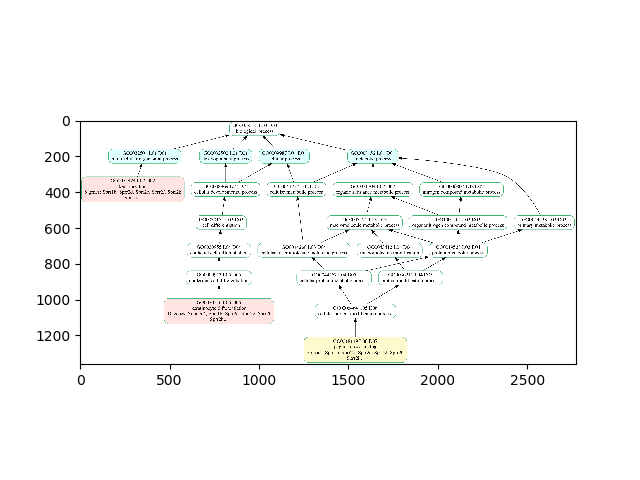

In [12]:
img=mpimg.imread(out+"mouse_salmonella_GO_enriched_BP.png")
plt.figure()
plt.imshow(img)
plt.show()

<IPython.core.display.Javascript object>


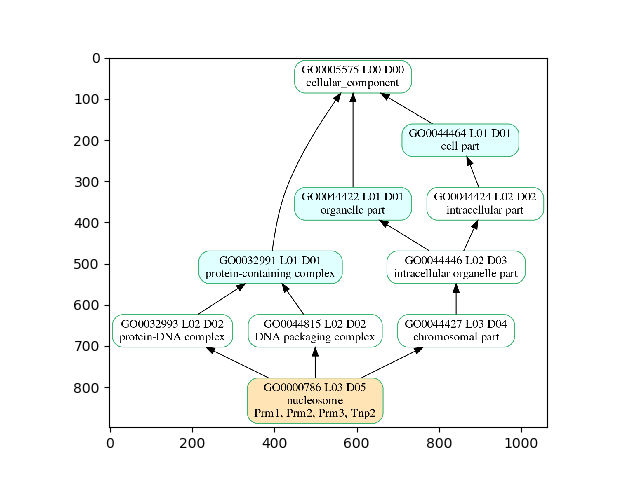

In [13]:
img=mpimg.imread(out+"mouse_salmonella_GO_enriched_CC.png")
plt.figure()
plt.imshow(img)
plt.show()